# Fitting a Weibull distribution 

Demonstates bassic functionality of WTTE. It uses Tensorflow to find the optimal A (alpha) and B (beta) of a pure [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution) distribution. Adapted from this [test](
https://github.com/ragulpr/wtte-rnn/blob/master/python/tests/test_tensorflow.py).

We start by importing libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pytest
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from wtte.objectives.tensorflow import loglik_continuous,loglik_discrete

## Define a function to Generate the Weibull data
Generate [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution) random variables using the inverse of the Weibull PDF. Specifically the inputs are:
 * A is alpha. By controlling A we control the time of failure. 
 * B is beta. By controlling B we control the peakedness of failure, we control how acute is failure around the failure point. 
 * C is the censoring point or time.
 
And the outputs are:
 * U is a censoring mask. The values are censored at C by using np.less_equal to find where the event time is less than or equal to C. If U is 0 then the value has been censored.

In [2]:
def generate_data(A,B,C,shape,discrete_time):
    x = np.random.uniform(0,1,shape)
    W = np.sort(A*np.power(-np.log(x),1/B))

    if discrete_time:
        C = np.floor(C)
        W = np.floor(W)

    U = np.less_equal(W, C)*1
    Y = np.minimum(W,C)    
    return W,Y,U

### Define parameters, generate the data, visualize the data
These are parameters you should play with to see how the plots below change, and later the fit. When we look at the plots we can consider it as a list of items that is n_samples long and each failure (or event) time. For example, we could imagine each item is an engine and the y axis is time in years.  When we censor the data (they grey line, left plot) we truncate the maxium values (right plot).

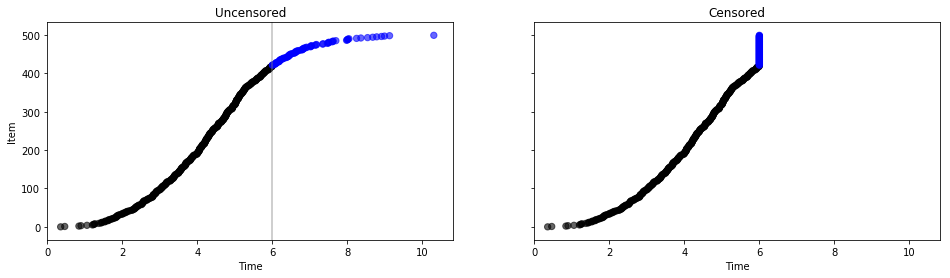

In [3]:
n_samples = 500
n_features = 1
real_a = 5
real_b = 3.0
censor_time = real_a*1.2
discrete_time=False
n_fit_steps = 2000

tte_actual,tte_censored,u_train = generate_data(
                                       A=real_a,
                                       B=real_b,
                                       C= censor_time, 
                                       shape=[n_samples,n_features], discrete_time=discrete_time)

tte_sorted = sorted(zip(tte_actual, tte_censored,u_train))
w, y ,u = [a[0] for a in tte_sorted],[a[1] for a in tte_sorted],[a[2] for a in tte_sorted]
colors = ["black" if c==1 else "blue" for c in u]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
ax1.scatter(w, range(len(w)), c=colors, s=40, alpha=.6)
ax1.axvline(censor_time, color="grey", alpha = .5)
ax2.scatter(y, range(len(w)), c=colors, s=40, alpha=.6)
ax1.set_ylabel('Item')
ax1.set_title("Uncensored")
ax2.set_title("Censored")
ax2.set_xlabel('Time')
ax1.set_xlabel('Time')
ax1.set_xlim([0, 1.05*tte_actual.max()])
ax2.set_xlim([0, 1.05*tte_actual.max()])
plt.show()

### Define Fit the function with Tensorflow.
We want to fit a Weibull distibution's parameters A and B. Our function tf_loglik_runner accepts the parameter loglik_fun that is the loss function to be minimized.

In [4]:
def tf_loglik_runner(loglik_fun, tte, tte_mask, n_steps = 2000):    
    y_ = tf.placeholder(tf.float32, shape=(None, 1))
    u_ = tf.placeholder(tf.float32, shape=(None, 1))
    
    a = tf.exp(tf.Variable(tf.random_normal([1], mean=2, stddev=1.0), name='a_weight'))
    b = tf.exp(tf.Variable(tf.random_normal([1], mean=2, stddev=1.0), name='b_weight'))
        
    loglik = loglik_fun(a, b, y_,u_) 
    
    loss = -tf.reduce_mean(loglik)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
    
    train_step = optimizer.minimize(loss)
    sess = tf.Session()
    
    sess.run(tf.global_variables_initializer())

    for step in range(n_steps):
        loss_val,_,a_val,b_val= sess.run([loss,train_step, a,b],feed_dict={y_: tte, u_ : tte_mask})
        if step % 1000 == 0:
            print("Step: %f, Loss value %s" % (step,loss_val))
            print ("Step: %f, A: %f B: %f" % (step,a_val, b_val))
    
    return a_val, b_val

### Run the fit
We call the fit with loss functions defined by WTTE.

In [5]:

if not discrete_time:
    a_val_uncen, b_val_uncen = tf_loglik_runner(loglik_continuous, tte_actual, u_train, n_steps = n_fit_steps)
    a_val_cen, b_val_cen = tf_loglik_runner(loglik_continuous, tte_censored, u_train, n_steps = n_fit_steps)
else:
    a_val_uncen, b_val_uncen = tf_loglik_runner(loglik_discrete, tte_actual, u_train,  n_steps = n_fit_steps)
    a_val_cen, b_val_cen = tf_loglik_runner(loglik_discrete, tte_censored, u_train, n_steps = n_fit_steps)
    
print ("Uncesnored case A: %f B: %f" % (a_val_uncen[0], b_val_uncen[0]))
print ("Cesnored case A: %f B: %f" % (a_val_cen[0], b_val_cen[0]))

Step: 0.000000, Loss value 9.95888
Step: 0.000000, A: 10.154819 B: 14.387989
Step: 1000.000000, Loss value 0.783317
Step: 1000.000000, A: 5.204939 B: 2.497488
Step: 0.000000, Loss value 1.77294
Step: 0.000000, A: 10.653006 B: 2.907313
Step: 1000.000000, Loss value 0.635145
Step: 1000.000000, A: 4.935078 B: 3.071780
Uncesnored case A: 5.204523 B: 2.495008
Cesnored case A: 4.935419 B: 3.076454


### Visualize results

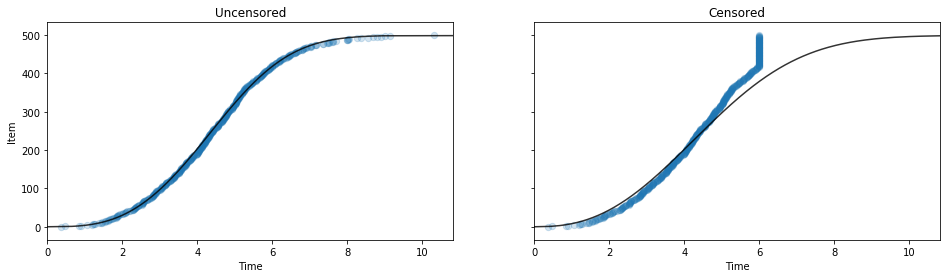

In [6]:
W_uncen = np.sort(a_val_cen * np.power(-np.log(np.linspace(1e-10,1.,n_samples)),1.0/b_val_cen))
W_cen = np.sort(a_val_uncen * np.power(-np.log(np.linspace(1e-10,1.,n_samples)),1.0/b_val_uncen))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
ax1.plot(W_uncen,range(len(tte_actual)), color="black", alpha=.8)
ax1.scatter(sorted(tte_actual), range(len(tte_actual)), marker="o", s=40, alpha=.2)
#ax1.axvline(censor_time, color="grey", alpha = .5)
ax2.plot(W_cen,range(len(tte_actual)), color="black", alpha=.8)
ax2.scatter(sorted(tte_censored), range(len(tte_actual)), s=40, alpha=.2)
ax1.set_ylabel('Item')
ax1.set_title("Uncensored")
ax2.set_title("Censored")
ax2.set_xlabel('Time')
ax1.set_xlabel('Time')
ax1.set_xlim([0, 1.05*tte_actual.max()])
ax2.set_xlim([0, 1.05*tte_actual.max()])
plt.show()

### We were able to recover the values of this Weibull distribution.
In tf_loglik_runner the inital values for a and b were chosen from a normal distribution with a mean of unity, indeed you may have noticed that if you drastically change real_a and real_b the fit fails. Can we overcome this problem by increasing n_fit_steps? Decreasing the step size? How can we choose these inital hyperparameters better?
